In [9]:
import sys
sys.path.insert(0,"../../../utilities/")
import data_utils
import p_value_calc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
import scipy.stats as st
import scipy.sparse as sp
import math

In [10]:
compartments = pd.read_csv("../../../data/K562/hg38/annotations/compartments.bg", sep = "\t", header = None)
compartments.columns = ['chr_name', 'start', 'end', 'c']
compartments = compartments[compartments.loc[:,'chr_name']=='chr1']
compartments_vector = sum([[c]*10 for c in compartments.loc[:,'c']],[])

In [11]:
def read_hic(infile):
    hic_data = pd.read_csv(infile, sep = "\t", header = None)
    hic_data = hic_data.dropna()
    hic_data.columns = ["source", "target", "weight"]
    hic_data['s'] = [int(s/25000) for s in hic_data['source']]
    hic_data['t'] = [int(t/25000) for t in hic_data['target']]
    hic_data['dist'] = [abs(s-t) for s,t in zip(hic_data['s'],hic_data['t'])]
    #hic_data['log2_weight'] = np.log2(hic_data['weight'])
    #min_w = hic_data['log2_weight'].min()
    #max_w = hic_data['log2_weight'].max()
    #w_cuts = np.linspace(min_w, max_w, 200)
    #hic_data['binned_weight'] = np.digitize(hic_data['log2_weight'], bins = w_cuts)
    #hic_data.loc[:,'s_c'] = [compartments_vector[p] for p in hic_data.loc[:,'s']]
    #hic_data.loc[:,'t_c'] = [compartments_vector[p] for p in hic_data.loc[:,'t']]
    #hic_data.loc[:,'c_diff'] = abs(hic_data.loc[:,'s_c'] - hic_data.loc[:,'t_c'])
    return hic_data

In [12]:
### check Hi-C ### 
vc_chr1_hic = read_hic("../../../data/K562/hg38/Hi-C/oe_25000_VC/chr1_chr1.txt")
kr_chr1_hic = read_hic("../../../data/K562/hg38/Hi-C/oe_25000_KR/chr1_chr1.txt")

In [5]:
ob_hic = read_hic("../../../data/K562/hg38/Hi-C/chr1_chr1.txt")

In [13]:
def create_mat(df, l, u):
    f_df = df[(df['s']>=l) & (df['s']<u) &
               (df['t']>=l) & (df['t']<u)]
    mat = sp.csr_matrix((f_df['weight'],(f_df['s']-l,f_df['t']-l)), 
                                 shape=(u-l,u-l))
    return(mat)

In [7]:
ob_mat = create_mat(ob_hic, 3000, 5000)

In [19]:
l = 3000
u = 5000
vc_mat = create_mat(vc_chr1_hic, l, u)
kr_mat = create_mat(kr_chr1_hic, l, u)

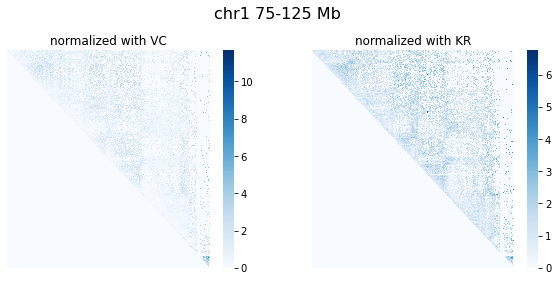

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (10,4))
sns.heatmap(np.arcsinh(vc_mat.toarray()), ax = axs[0], cmap = 'Blues')
axs[0].set_title('normalized with VC')
axs[0].set(xticklabels = [], yticklabels = [])
axs[0].tick_params(left=False, bottom=False)
sns.heatmap(np.arcsinh(kr_mat.toarray()), ax = axs[1], cmap = 'Blues')
axs[1].set_title('normalized with KR')
axs[1].set(xticklabels = [], yticklabels = [])
axs[1].tick_params(left=False, bottom=False)
fig.suptitle('chr1 {}-{} Mb'.format(int(l/40),int(u/40)), fontsize=16, ha = 'center', va = 'bottom')
fig.savefig('results/norm_comp.jpeg', bbox_inches='tight', facecolor='white', transparent=False)

<AxesSubplot:>

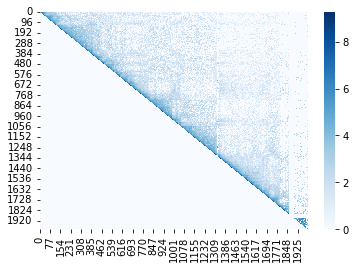

In [8]:
sns.heatmap(np.arcsinh(ob_mat.toarray()), cmap = 'Blues')

In [25]:
vc_pvalues = vc_hic.groupby('dist')['weibull p-value'].mean().reset_index()

<AxesSubplot:xlabel='dist', ylabel='weibull p-value'>

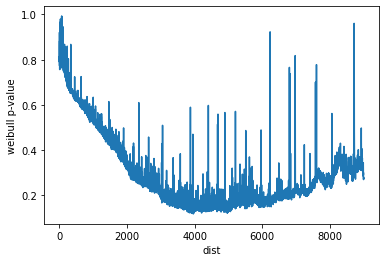

In [26]:
sns.lineplot(x=vc_pvalues['dist'][0:9000],y=vc_pvalues['weibull p-value'][0:9000])

In [3]:
### check Hi-C ### 
kr_chr1_hic = pd.read_csv("../../../data/K562/Hi-C/hg38/chr1_chr1.txt", sep = "\t", header = None)
kr_chr1_hic = kr_chr1_hic.dropna()
kr_chr1_hic.columns = ["source", "target", "weight"]
kr_chr1_hic['s'] = [int(s/25000) for s in kr_chr1_hic['source']]
kr_chr1_hic['t'] = [int(t/25000) for t in kr_chr1_hic['target']]
kr_chr1_hic['dist'] = [abs(s-t) for s,t in zip(kr_chr1_hic['s'],kr_chr1_hic['t'])]

In [9]:
p_value_calc.p_value_calc(kr_chr1_hic)

../../../utilities/p_value_calc.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['weibull p-value'] = p_values


In [16]:
kr_pvalues = kr_chr1_hic.groupby('dist')['weibull p-value'].mean().reset_index()

In [27]:
kr_weights = kr_chr1_hic.groupby('dist')['weight'].mean().reset_index()

<AxesSubplot:xlabel='dist', ylabel='weibull p-value'>

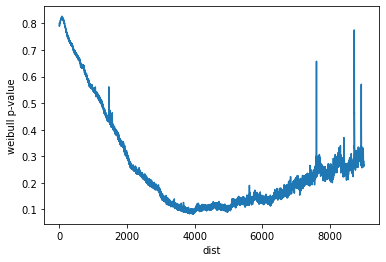

In [21]:
sns.lineplot(x=kr_pvalues['dist'][0:9000],y=kr_pvalues['weibull p-value'][0:9000])

<AxesSubplot:xlabel='dist', ylabel='weight'>

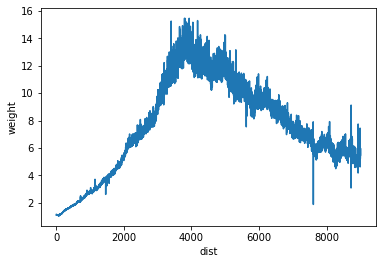

In [28]:
sns.lineplot(x=kr_weights['dist'][0:9000],y=kr_weights['weight'][0:9000])

In [30]:
vc_means = vc_chr1_hic.groupby('dist')['weight'].mean().reset_index()
kr_means = kr_chr1_hic.groupby('dist')['weight'].mean().reset_index()

<AxesSubplot:ylabel='weight'>

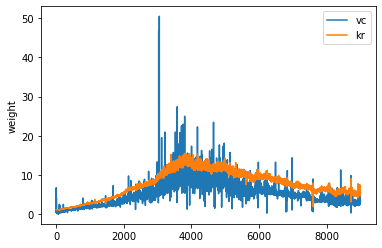

In [31]:
sns.lineplot(x = np.arange(9000), y = vc_means['weight'][:9000], label = 'vc')
sns.lineplot(x = np.arange(9000), y = kr_means['weight'][:9000], label = 'kr')

In [28]:
vc_chr1_hic

,source,target,weight,dist,s,t
0,0,0,43.221820,0,0,0
1,25000,25000,57.653107,0,1,1
2,25000,50000,59.843260,1,1,2
3,50000,50000,68.967120,0,2,2
4,0,75000,161.000170,3,0,3
5,25000,75000,102.553085,2,1,3
6,50000,75000,70.403830,1,2,3
7,75000,75000,73.562580,0,3,3
8,0,100000,24.415403,4,0,4
9,25000,100000,52.852467,3,1,4


In [21]:
m = vc_chr1_hic[(vc_chr1_hic['s']<100) & (vc_chr1_hic['t']<100)]

In [25]:
m_mat = np.zeros((100,100))
for i,row in m.iterrows():
    m_mat[int(row['s']),int(row['t'])] = row['weight']
    m_mat[int(row['t']),int(row['s'])] = row['weight']

/home/nedooshki/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

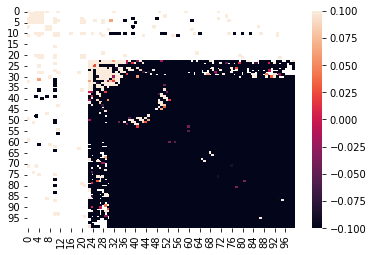

In [27]:
sns.heatmap(np.log2(m_mat))